<a name='0_0'></a>
# <span style="color:#ff5f27">👨🏻‍🏫 LSTM GRU </span>

🗄️ Table of Contents:

- [📝 Imports](#0)
- [💽 Sinewave Data](#1)
    - [🤖 Model Building](#11)
- [💽 Generated Data](#2)
    - [🤖 Model Building](#21)
- [💽 NY Stock Price](#3)
    - [👨🏻‍🍳 Data Preparation](#31)
    - [🤖 Model Building](#32)
    - [📝 Results](#33)

<a name='0'></a>
## <span style="color:#ff5f27">📝 Imports </span>
- [🗄️ Table of Contents](#0_0)

In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import os
import math 
import sklearn 
import sklearn.preprocessing 
import datetime 
import tensorflow as tf 
import random
from tensorflow.random import set_seed

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense

import warnings
warnings.filterwarnings('ignore')

2023-11-09 01:15:04.831967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name='1'></a>
## <span style="color:#ff5f27">💽 Sinewave Data </span>
- [🗄️ Table of Contents](#0_0)

In [2]:
def reset_seeds(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value) 
    random.seed(seed_value)
    set_seed(seed_value)

In [3]:
def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [4]:
def load_data(dataset, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = dataset.loc[:,column]
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)
    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [5]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

In [6]:
def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 

In [7]:
# Load the data 
dataset = pd.read_csv('data/sinewave.csv') 
dataset.head(3)

,sinewave
0,0.841471
1,0.873736
2,0.902554


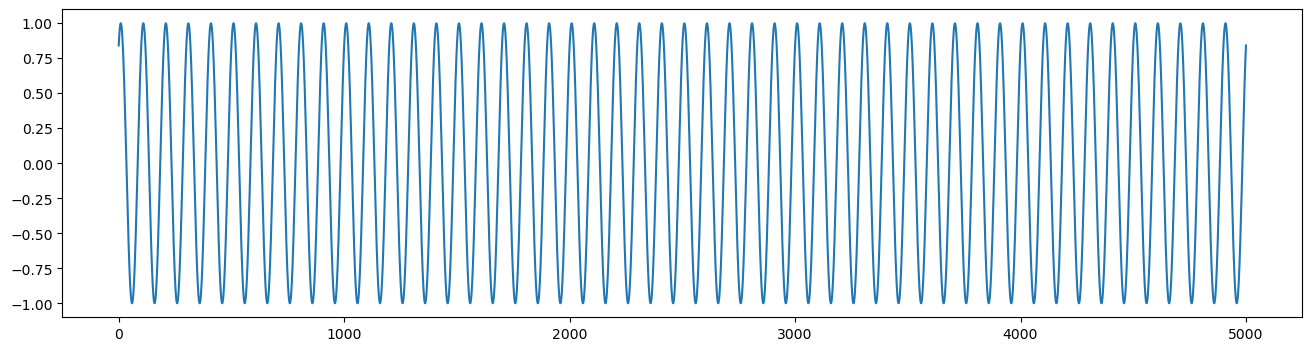

In [8]:
dataset["sinewave"][:].plot(figsize=(16,4),legend=False) 
plt.show()

In [9]:
ENROL_WINDOW = 100

feature_train, label_train, feature_test, label_test = load_data(
    dataset, 
    'sinewave', 
    ENROL_WINDOW, 
    False,
) 
print('Datasets generated') 

Datasets generated


<a name='11'></a>
## <span style="color:#ff5f27">🤖 Model Building</span>
- [🗄️ Table of Contents](#0_0)

In [10]:
reset_seeds()
model = Sequential() 
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1))) 
model.add(Dropout(0.2)) 
model.add(LSTM(100, return_sequences=False)) 
model.add(Dropout(0.2)) 
model.add(Dense(1, activation = "linear"))

model.compile(
    loss='mse', 
    optimizer='adam',
) 

2023-11-09 01:15:11.546690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model.fit(
    feature_train, 
    label_train, 
    batch_size=512, 
    epochs=10, 
    validation_data=(feature_test, label_test),
)

Epoch 1/10
9/9 [==============================] - 8s 575ms/step - loss: 0.2591 - val_loss: 0.1174
Epoch 2/10
9/9 [==============================] - 5s 500ms/step - loss: 0.0675 - val_loss: 0.0189
Epoch 3/10
9/9 [==============================] - 4s 499ms/step - loss: 0.0142 - val_loss: 0.0067
Epoch 4/10
9/9 [==============================] - 5s 505ms/step - loss: 0.0073 - val_loss: 0.0030
Epoch 5/10
9/9 [==============================] - 5s 499ms/step - loss: 0.0069 - val_loss: 0.0010
Epoch 6/10
9/9 [==============================] - 5s 501ms/step - loss: 0.0050 - val_loss: 5.4605e-04
Epoch 7/10
9/9 [==============================] - 5s 502ms/step - loss: 0.0046 - val_loss: 3.1301e-04
Epoch 8/10
9/9 [==============================] - 5s 524ms/step - loss: 0.0041 - val_loss: 3.0047e-04
Epoch 9/10
9/9 [==============================] - 4s 496ms/step - loss: 0.0040 - val_loss: 1.5777e-04
Epoch 10/10
9/9 [==============================] - 5s 501ms/step - loss: 0.0037 - val_loss: 1.6467e-04

In [12]:
predictions = predict_sequence_full(
    model, 
    feature_test, 
    ENROL_WINDOW,
) 

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


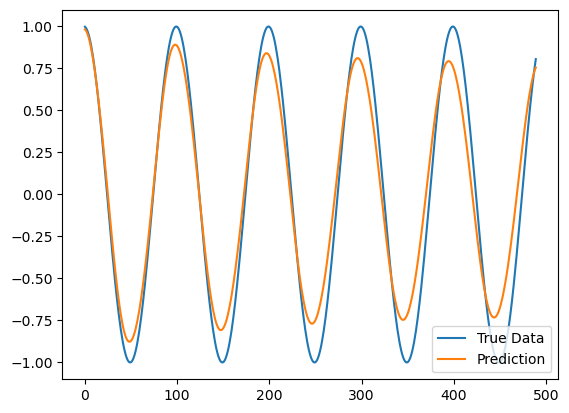

In [13]:
plot_results(predictions,label_test)

In [14]:
reset_seeds()
model = Sequential() 
model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],1))) 
model.add(Dropout(0.2)) 
model.add(GRU(100, return_sequences=False)) 
model.add(Dropout(0.2)) 
model.add(Dense(1, activation = "linear"))

model.compile(
    loss='mse', 
    optimizer='adam',
) 

In [15]:
model.fit(
    feature_train, 
    label_train, 
    batch_size=512, 
    epochs=10, 
    validation_data=(feature_test, label_test),
)

Epoch 1/10
9/9 [==============================] - 6s 449ms/step - loss: 0.2863 - val_loss: 0.0368
Epoch 2/10
9/9 [==============================] - 3s 383ms/step - loss: 0.0595 - val_loss: 0.0292
Epoch 3/10
9/9 [==============================] - 3s 383ms/step - loss: 0.0295 - val_loss: 0.0283
Epoch 4/10
9/9 [==============================] - 3s 383ms/step - loss: 0.0262 - val_loss: 0.0159
Epoch 5/10
9/9 [==============================] - 3s 382ms/step - loss: 0.0198 - val_loss: 0.0138
Epoch 6/10
9/9 [==============================] - 3s 387ms/step - loss: 0.0166 - val_loss: 0.0116
Epoch 7/10
9/9 [==============================] - 3s 383ms/step - loss: 0.0144 - val_loss: 0.0085
Epoch 8/10
9/9 [==============================] - 3s 384ms/step - loss: 0.0117 - val_loss: 0.0062
Epoch 9/10
9/9 [==============================] - 3s 388ms/step - loss: 0.0102 - val_loss: 0.0039
Epoch 10/10
9/9 [==============================] - 3s 382ms/step - loss: 0.0075 - val_loss: 0.0019


In [16]:
predictions = predict_sequence_full(
    model, 
    feature_test, 
    ENROL_WINDOW,
) 

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


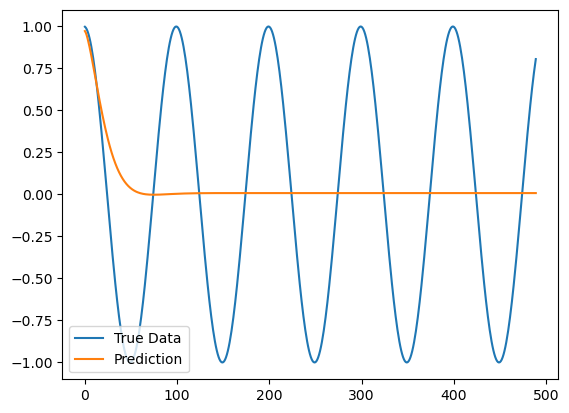

In [17]:
plot_results(predictions,label_test)

<a name='2'></a>
## <span style="color:#ff5f27">💽 Generated Data </span>
- [🗄️ Table of Contents](#0_0)

In [18]:
def generate_wave(cycles, resolution):
    length = np.pi * 2 * cycles
    sine_wave = np.cos(np.arange(0, length, length / resolution))
    return sine_wave

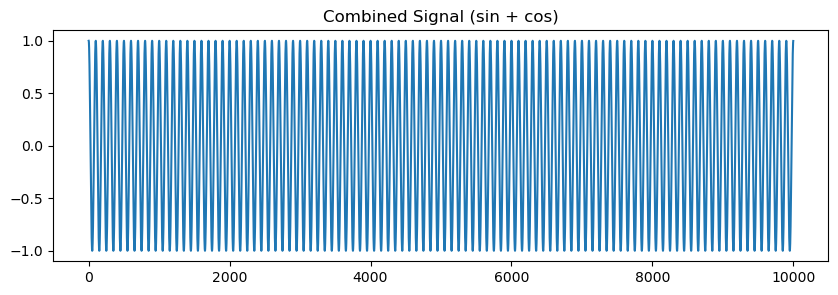

In [19]:
wave = generate_wave(
    cycles=100, 
    resolution=10_000,
)

plt.figure(figsize=(10, 3))

plt.plot(range(len(wave)), wave)
plt.title('Combined Signal (sin + cos)')
plt.show()

In [20]:
wave_df = pd.DataFrame({'wave':wave})
wave_df.head(3)

,wave
0,1.000000
1,0.998027
2,0.992115


In [21]:
Enrol_window = 200
X_train, y_train, X_test, y_test = load_data(wave_df, 'wave', Enrol_window, False)
print('enrol window set to', Enrol_window)
print('Datasets generated')

enrol window set to 200
Datasets generated


<a name='21'></a>
## <span style="color:#ff5f27">🤖 Model Building</span>
- [🗄️ Table of Contents](#0_0)

In [22]:
reset_seeds()
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(
    loss='mse', 
    optimizer='adam',
)
print('model compiled')
print(model.summary())

history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=10,
    validation_data=(X_test, y_test)
)

model compiled
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200, 50)           10400     
                                                                 
 dropout_4 (Dropout)         (None, 200, 50)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
18/18 [============

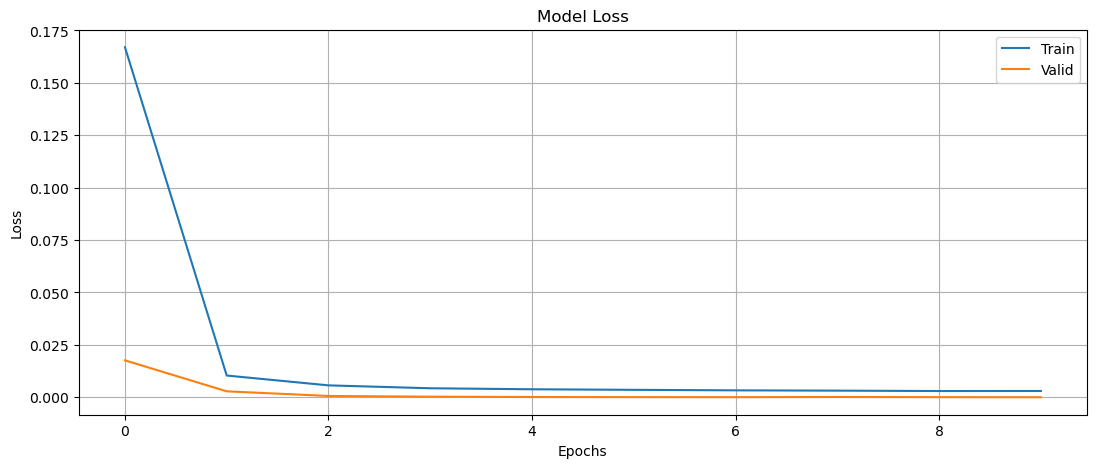

In [23]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.grid()
plt.show()

In [24]:
predictions = predict_sequence_full(
    model, 
    X_test, 
    Enrol_window,
)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


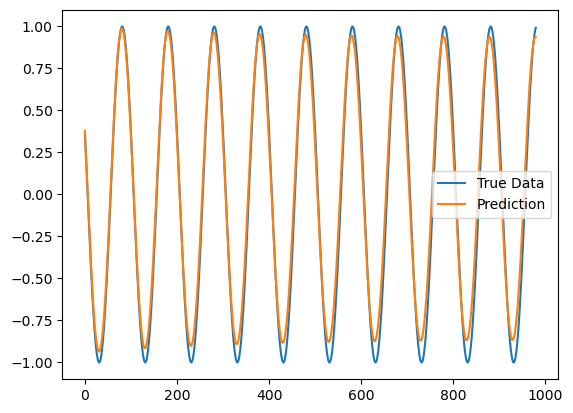

In [25]:
plot_results(
    predictions, 
    y_test,
)

In [26]:
reset_seeds()
model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(100, return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1, activation = "linear"))

model_gru.compile(
    loss='mse', 
    optimizer='adam',
)
print('model compiled')
print(model_gru.summary())

history_gru = model_gru.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=10,
    validation_data=(X_test, y_test)
)

model compiled
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 200, 50)           7950      
                                                                 
 dropout_6 (Dropout)         (None, 200, 50)           0         
                                                                 
 gru_3 (GRU)                 (None, 100)               45600     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 53,651
Trainable params: 53,651
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
18/18 [============

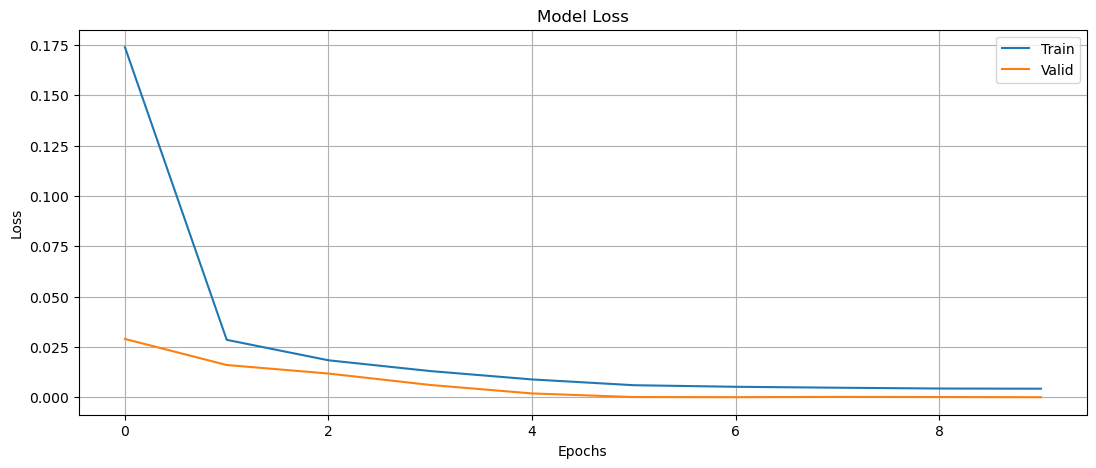

In [27]:
plt.figure(figsize=(13, 5))
plt.plot(history_gru.history['loss'])
plt.plot(history_gru.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.grid()
plt.show()

In [28]:
predictions = predict_sequence_full(
    model_gru, 
    X_test, 
    Enrol_window,
)

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


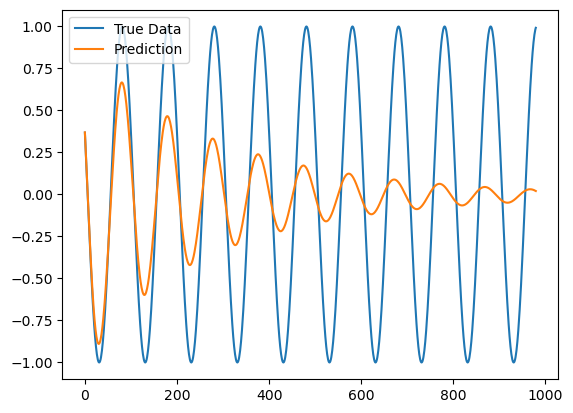

In [29]:
plot_results(
    predictions, 
    y_test,
)

<a name='3'></a>
## <span style="color:#ff5f27">💽 NY Stock Price Data </span>
- [🗄️ Table of Contents](#0_0)

In [30]:
df = pd.read_csv("data/prices-split-adjusted.csv", index_col = 0) 
df.info() 
df.head(3) 

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0


In [31]:
# number of different stocks 
print('\nnumber of different stocks: ', len(list(set(df.symbol)))) 
print(list(set(df.symbol))[:10]) 


number of different stocks:  501
['XRX', 'ABT', 'WYNN', 'MCHP', 'DOW', 'ISRG', 'CERN', 'NTAP', 'UPS', 'XRAY']


<a name='31'></a>
## <span style="color:#ff5f27">👨🏻‍🍳 Data Preparation </span>
- [🗄️ Table of Contents](#0_0)

In [32]:
def normalize_data(df): 
    min_max_scaler = sklearn.preprocessing.MinMaxScaler() 
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1)) 
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1)) 
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1)) 
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1)) 
    return df 

In [33]:
def load_data(stock, seq_len): 
    data_raw = stock.to_numpy() # convert to numpy array 
    data = [] 
    # create all possible sequences of length seq_len 
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len]) 
    data = np.array(data); 
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0])); 
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0])); 
    train_set_size = data.shape[0] - (valid_set_size + test_set_size); 
    x_train = data[:train_set_size,:-1,:] 
    y_train = data[:train_set_size,-1,:] 
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:] 
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:] 
    x_test = data[train_set_size+valid_set_size:,:-1,:] 
    y_test = data[train_set_size+valid_set_size:,-1,:] 
    return [x_train, y_train, x_valid, y_valid, x_test, y_test] 

In [34]:
def plot_loss(history, scores_df, model_name):
    
    train_loss = history.history["loss"][-1]
    val_loss = history.history["val_loss"][-1]

    new_scores_df = pd.DataFrame(
        {
            'model_name': [model_name], 
            'train_loss': [train_loss], 
            'val_loss': [val_loss],
        }
    )
    scores_df = pd.concat([scores_df, new_scores_df],ignore_index=True)
    
    print(f'🎯 Train Loss: {train_loss}')
    print(f'🎯 Val Loss: {val_loss}')
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    ax.plot(history.history['loss'], label="train loss")
    ax.plot(history.history['val_loss'], label="validation loss")
    ax.set_title("Loss")
    ax.set_xlabel("Number of Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

    plt.show()
    
    return scores_df

In [35]:
def plot_predictions(
    y_train, 
    y_valid, 
    y_test, 
    y_train_pred, 
    y_valid_pred, 
    y_test_pred,
):
    ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest
    ## show predictions
    plt.figure(figsize=(15, 5)); plt.subplot(1,2,1);

    plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
    color='gray', label='valid target')

    plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0], y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
    y_test[:,ft], color='black', label='test target')

    plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
    label='train prediction')

    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
    y_valid_pred[:,ft], color='orange', label='valid prediction')

    plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
    y_test_pred[:,ft], color='green', label='test prediction')

    plt.title('past and future stock prices') 
    plt.xlabel('time [days]') 
    plt.ylabel('normalized price') 
    plt.legend(loc='best')

    plt.subplot(1,2,2)

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
    y_test[:,ft], color='black', label='test target')

    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
    y_test_pred[:,ft], color='green', label='test prediction')

    plt.title('future stock prices') 
    plt.xlabel('time [days]') 
    plt.ylabel('normalized price') 
    plt.legend(loc='best');
    return

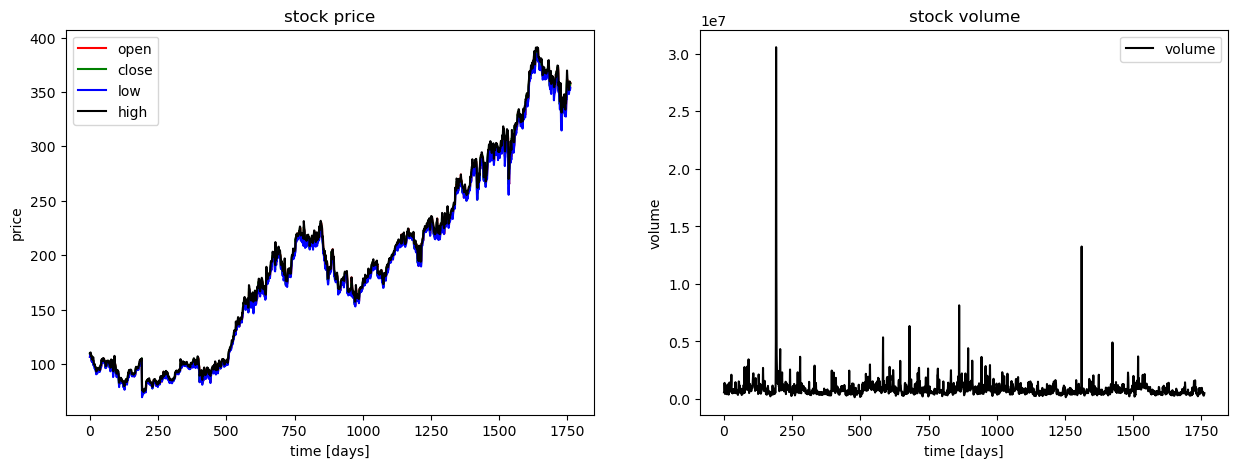

In [36]:
plt.figure(figsize=(15, 5)); 
plt.subplot(1,2,1); 
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open') 
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close') 
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low') 
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high') 
plt.title('stock price') 
plt.xlabel('time [days]') 
plt.ylabel('price') 
plt.legend(loc='best') 
plt.subplot(1,2,2); 
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume') 
plt.title('stock volume') 
plt.xlabel('time [days]') 
plt.ylabel('volume') 
plt.legend(loc='best');

In [37]:
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

In [38]:
df_stock = df[df.symbol == 'EQIX'].copy() 
df_stock.drop(['symbol'], 1, inplace=True)
df_stock.drop(['volume'], 1, inplace=True) 
cols = list(df_stock.columns.values) 
print('df_stock.columns.values = ', cols) 

df_stock.columns.values =  ['open', 'close', 'low', 'high']


In [39]:
# normalize stock 
df_stock_norm = df_stock.copy() 
df_stock_norm = normalize_data(df_stock_norm) 

# create train, test data 
seq_len = 20
X_train, y_train, X_valid, y_valid, X_test, y_test = load_data(df_stock_norm, seq_len)

print('x_train.shape = ',X_train.shape) 
print('y_train.shape = ', y_train.shape) 
print('x_valid.shape = ',X_valid.shape) 
print('y_valid.shape = ', y_valid.shape) 
print('x_test.shape = ', X_test.shape) 
print('y_test.shape = ',y_test.shape) 

x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


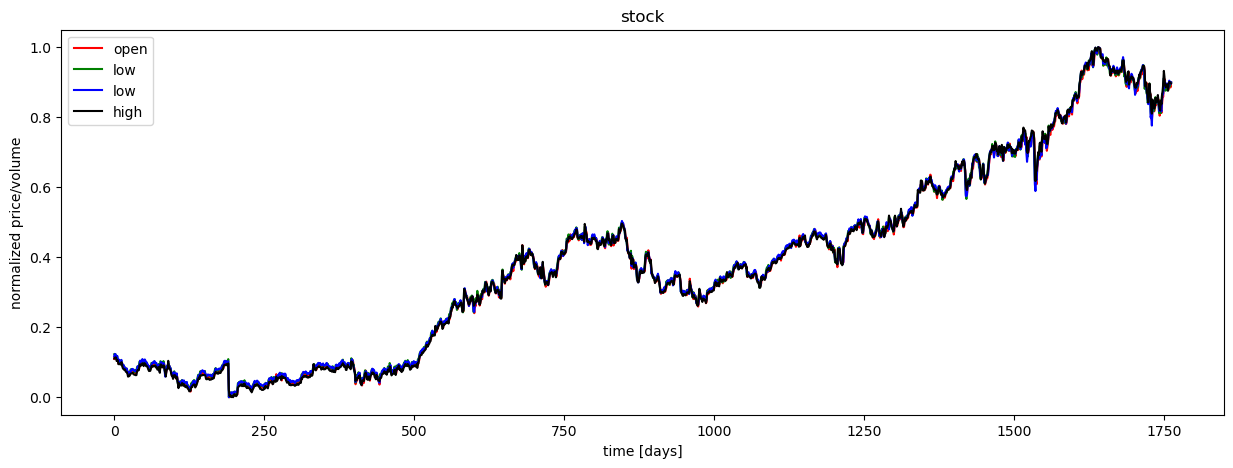

In [40]:
plt.figure(figsize=(15, 5)); 
plt.plot(df_stock_norm.open.values, color='red', label='open') 
plt.plot(df_stock_norm.close.values, color='green', label='low') 
plt.plot(df_stock_norm.low.values, color='blue', label='low') 
plt.plot(df_stock_norm.high.values, color='black', label='high') 
plt.title('stock') 
plt.xlabel('time [days]') 
plt.ylabel('normalized price/volume') 
plt.legend(loc='best') 
plt.show()

<a name='32'></a>
## <span style="color:#ff5f27">🤖 Model Building</span>
- [🗄️ Table of Contents](#0_0)

In [41]:
scores_df = pd.DataFrame(columns=['model_name', 'train_loss', 'val_loss'])
scores_df

,model_name,train_loss,val_loss


In [42]:
reset_seeds()
model_init = Sequential()
model_init.add(LSTM(200, input_shape=(X_train.shape[1], 4), return_sequences=True))
model_init.add(LSTM(200))
model_init.add(Dense(4, activation = "linear"))
model_init.compile(
    loss='mse', 
    optimizer='adam',
) 

In [43]:
history_init = model_init.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=100, 
    validation_split=0.2,
)

Epoch 1/100
23/23 [==============================] - 4s 88ms/step - loss: 0.0066 - val_loss: 0.0026
Epoch 2/100
23/23 [==============================] - 1s 61ms/step - loss: 4.3996e-04 - val_loss: 6.2406e-04
Epoch 3/100
23/23 [==============================] - 1s 62ms/step - loss: 3.1181e-04 - val_loss: 4.8596e-04
Epoch 4/100
23/23 [==============================] - 1s 61ms/step - loss: 3.0742e-04 - val_loss: 8.0839e-04
Epoch 5/100
23/23 [==============================] - 1s 61ms/step - loss: 3.0988e-04 - val_loss: 0.0011
Epoch 6/100
23/23 [==============================] - 1s 62ms/step - loss: 3.0147e-04 - val_loss: 4.6587e-04
Epoch 7/100
23/23 [==============================] - 1s 62ms/step - loss: 2.9299e-04 - val_loss: 3.9622e-04
Epoch 8/100
23/23 [==============================] - 1s 62ms/step - loss: 3.2922e-04 - val_loss: 0.0013
Epoch 9/100
23/23 [==============================] - 1s 61ms/step - loss: 3.8172e-04 - val_loss: 0.0012
Epoch 10/100
23/23 [============================

23/23 [==============================] - 1s 61ms/step - loss: 9.1048e-05 - val_loss: 1.1386e-04
Epoch 77/100
23/23 [==============================] - 1s 61ms/step - loss: 8.8783e-05 - val_loss: 8.6937e-05
Epoch 78/100
23/23 [==============================] - 1s 62ms/step - loss: 7.8139e-05 - val_loss: 1.2484e-04
Epoch 79/100
23/23 [==============================] - 1s 61ms/step - loss: 8.9960e-05 - val_loss: 1.2117e-04
Epoch 80/100
23/23 [==============================] - 1s 61ms/step - loss: 7.9821e-05 - val_loss: 9.6283e-05
Epoch 81/100
23/23 [==============================] - 1s 61ms/step - loss: 7.6088e-05 - val_loss: 7.9935e-05
Epoch 82/100
23/23 [==============================] - 1s 61ms/step - loss: 7.8742e-05 - val_loss: 1.9376e-04
Epoch 83/100
23/23 [==============================] - 1s 60ms/step - loss: 8.0391e-05 - val_loss: 1.1478e-04
Epoch 84/100
23/23 [==============================] - 1s 61ms/step - loss: 7.5412e-05 - val_loss: 9.3227e-05
Epoch 85/100
23/23 [============

🎯 Train Loss: 6.704758561681956e-05
🎯 Val Loss: 7.048016414046288e-05


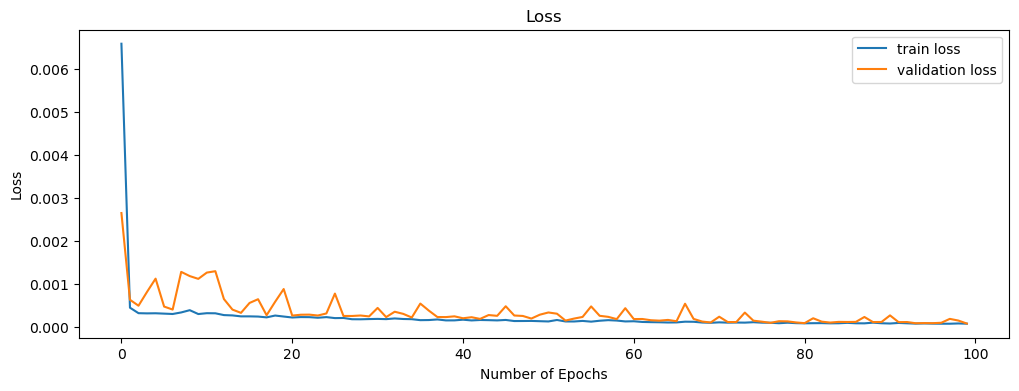

In [44]:
scores_df = plot_loss(
    history_init,
    scores_df, 
    'LSTM_2x200',
)

6/6 [==============================] - 0s 16ms/step


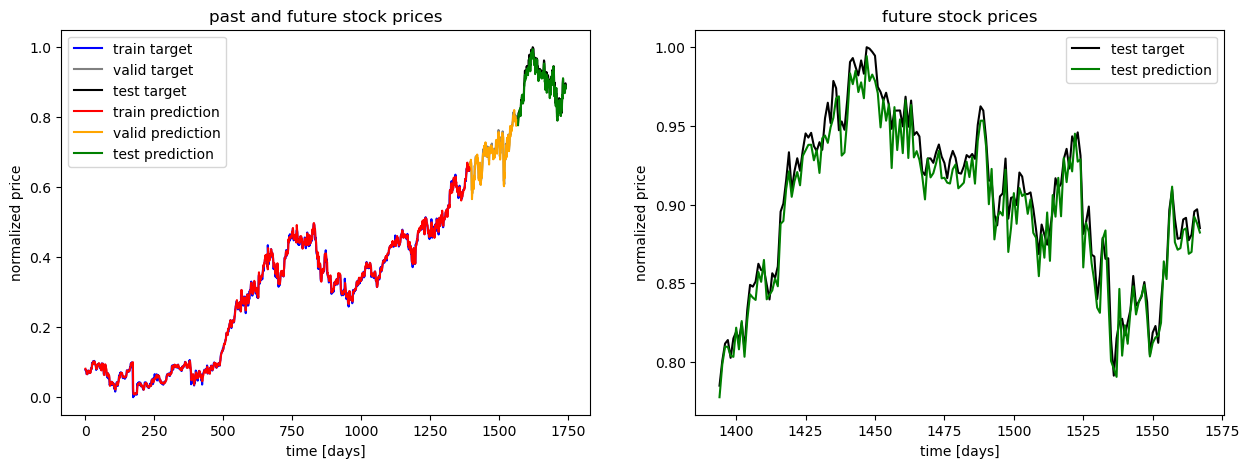

In [45]:
y_train_pred = model_init.predict(X_train)
y_test_pred = model_init.predict(X_test)
y_valid_pred = model_init.predict(X_valid)

plot_predictions(
    y_train, 
    y_valid, 
    y_test, 
    y_train_pred, 
    y_valid_pred, 
    y_test_pred,
)

In [46]:
reset_seeds()
model_gru = Sequential()
model_gru.add(GRU(200, input_shape=(X_train.shape[1], 4), return_sequences=True))
model_gru.add(GRU(200))
model_gru.add(Dense(4, activation = "linear"))
model_gru.compile(
    loss='mse', 
    optimizer='adam',
) 

In [47]:
history_gru = model_gru.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=100, 
    validation_split=0.2,
)

Epoch 1/100
23/23 [==============================] - 4s 72ms/step - loss: 0.0094 - val_loss: 9.4961e-04
Epoch 2/100
23/23 [==============================] - 1s 47ms/step - loss: 3.8154e-04 - val_loss: 4.4394e-04
Epoch 3/100
23/23 [==============================] - 1s 48ms/step - loss: 1.5651e-04 - val_loss: 1.7389e-04
Epoch 4/100
23/23 [==============================] - 1s 47ms/step - loss: 1.3795e-04 - val_loss: 1.9344e-04
Epoch 5/100
23/23 [==============================] - 1s 48ms/step - loss: 1.3649e-04 - val_loss: 2.2802e-04
Epoch 6/100
23/23 [==============================] - 1s 47ms/step - loss: 1.3237e-04 - val_loss: 1.7294e-04
Epoch 7/100
23/23 [==============================] - 1s 49ms/step - loss: 1.2739e-04 - val_loss: 1.5450e-04
Epoch 8/100
23/23 [==============================] - 1s 47ms/step - loss: 1.2531e-04 - val_loss: 2.0704e-04
Epoch 9/100
23/23 [==============================] - 1s 48ms/step - loss: 1.3183e-04 - val_loss: 2.0525e-04
Epoch 10/100
23/23 [============

23/23 [==============================] - 1s 49ms/step - loss: 7.1808e-05 - val_loss: 1.3818e-04
Epoch 77/100
23/23 [==============================] - 1s 47ms/step - loss: 8.2512e-05 - val_loss: 9.4994e-05
Epoch 78/100
23/23 [==============================] - 1s 47ms/step - loss: 6.3972e-05 - val_loss: 8.9676e-05
Epoch 79/100
23/23 [==============================] - 1s 47ms/step - loss: 8.5148e-05 - val_loss: 8.0892e-05
Epoch 80/100
23/23 [==============================] - 1s 47ms/step - loss: 6.8896e-05 - val_loss: 7.9803e-05
Epoch 81/100
23/23 [==============================] - 1s 47ms/step - loss: 6.2459e-05 - val_loss: 7.2960e-05
Epoch 82/100
23/23 [==============================] - 1s 47ms/step - loss: 6.9414e-05 - val_loss: 9.1685e-05
Epoch 83/100
23/23 [==============================] - 1s 48ms/step - loss: 6.7128e-05 - val_loss: 8.8471e-05
Epoch 84/100
23/23 [==============================] - 1s 47ms/step - loss: 6.3741e-05 - val_loss: 9.8745e-05
Epoch 85/100
23/23 [============

🎯 Train Loss: 6.31176371825859e-05
🎯 Val Loss: 6.957186997169629e-05


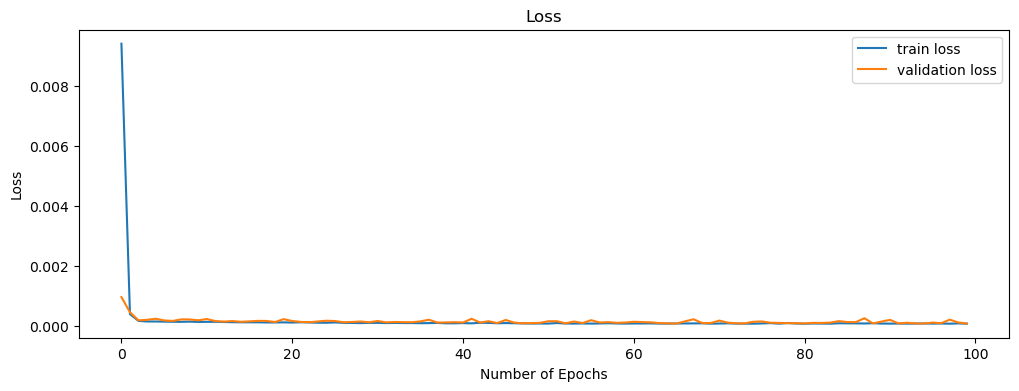

In [48]:
scores_df = plot_loss(
    history_gru,
    scores_df, 
    'GRU_2x200',
)

6/6 [==============================] - 0s 11ms/step


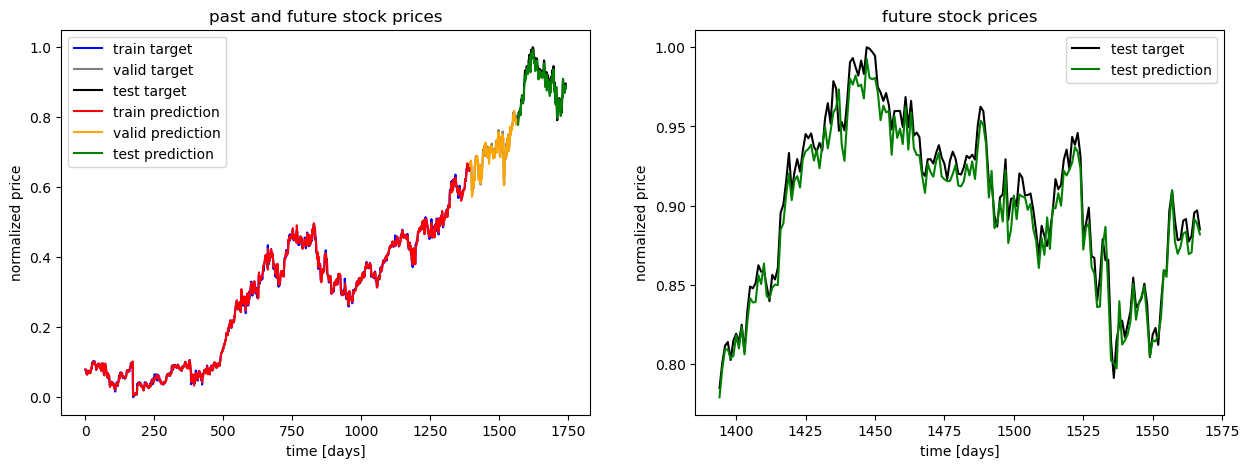

In [49]:
y_train_pred = model_gru.predict(X_train)
y_test_pred = model_gru.predict(X_test)
y_valid_pred = model_gru.predict(X_valid)

plot_predictions(
    y_train, 
    y_valid, 
    y_test, 
    y_train_pred, 
    y_valid_pred, 
    y_test_pred,
)

In [50]:
scores_df

,model_name,train_loss,val_loss
0,LSTM_2x200,0.000067,0.00007
1,GRU_2x200,0.000063,0.00007


In [51]:
reset_seeds()
model_lstm256 = Sequential()
model_lstm256.add(LSTM(256, input_shape=(X_train.shape[1], 4), return_sequences=True))
model_lstm256.add(LSTM(256))
model_lstm256.add(Dense(1, activation = "linear"))
model_lstm256.compile(
    loss='mse', 
    optimizer='adam',
) 

In [52]:
history_lstm256 = model_lstm256.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=100, 
    validation_split=0.2,
)

Epoch 1/100
23/23 [==============================] - 5s 115ms/step - loss: 0.0071 - val_loss: 3.7313e-04
Epoch 2/100
23/23 [==============================] - 2s 89ms/step - loss: 4.2086e-04 - val_loss: 4.5022e-04
Epoch 3/100
23/23 [==============================] - 2s 89ms/step - loss: 2.5585e-04 - val_loss: 4.2498e-04
Epoch 4/100
23/23 [==============================] - 2s 89ms/step - loss: 2.4481e-04 - val_loss: 3.5028e-04
Epoch 5/100
23/23 [==============================] - 2s 88ms/step - loss: 2.2688e-04 - val_loss: 6.5967e-04
Epoch 6/100
23/23 [==============================] - 2s 89ms/step - loss: 2.2585e-04 - val_loss: 3.2520e-04
Epoch 7/100
23/23 [==============================] - 2s 89ms/step - loss: 2.1851e-04 - val_loss: 3.1726e-04
Epoch 8/100
23/23 [==============================] - 2s 89ms/step - loss: 2.2811e-04 - val_loss: 2.9368e-04
Epoch 9/100
23/23 [==============================] - 2s 90ms/step - loss: 2.1629e-04 - val_loss: 2.5384e-04
Epoch 10/100
23/23 [===========

23/23 [==============================] - 2s 89ms/step - loss: 8.7169e-05 - val_loss: 8.5028e-05
Epoch 77/100
23/23 [==============================] - 2s 88ms/step - loss: 8.9218e-05 - val_loss: 8.2526e-05
Epoch 78/100
23/23 [==============================] - 2s 89ms/step - loss: 7.9786e-05 - val_loss: 1.1434e-04
Epoch 79/100
23/23 [==============================] - 2s 89ms/step - loss: 8.6760e-05 - val_loss: 9.1461e-05
Epoch 80/100
23/23 [==============================] - 2s 91ms/step - loss: 8.1613e-05 - val_loss: 1.0330e-04
Epoch 81/100
23/23 [==============================] - 2s 89ms/step - loss: 8.0027e-05 - val_loss: 7.8923e-05
Epoch 82/100
23/23 [==============================] - 2s 90ms/step - loss: 8.0772e-05 - val_loss: 1.5836e-04
Epoch 83/100
23/23 [==============================] - 2s 89ms/step - loss: 8.2457e-05 - val_loss: 1.0142e-04
Epoch 84/100
23/23 [==============================] - 2s 88ms/step - loss: 7.6140e-05 - val_loss: 8.1042e-05
Epoch 85/100
23/23 [============

🎯 Train Loss: 7.035562884993851e-05
🎯 Val Loss: 7.64949363656342e-05


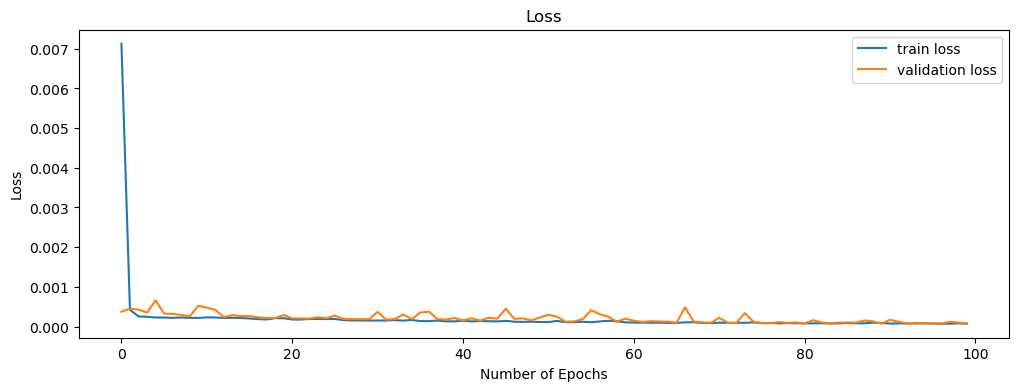

In [53]:
scores_df = plot_loss(
    history_lstm256,
    scores_df, 
    'LSTM_2x256',
)

6/6 [==============================] - 0s 20ms/step


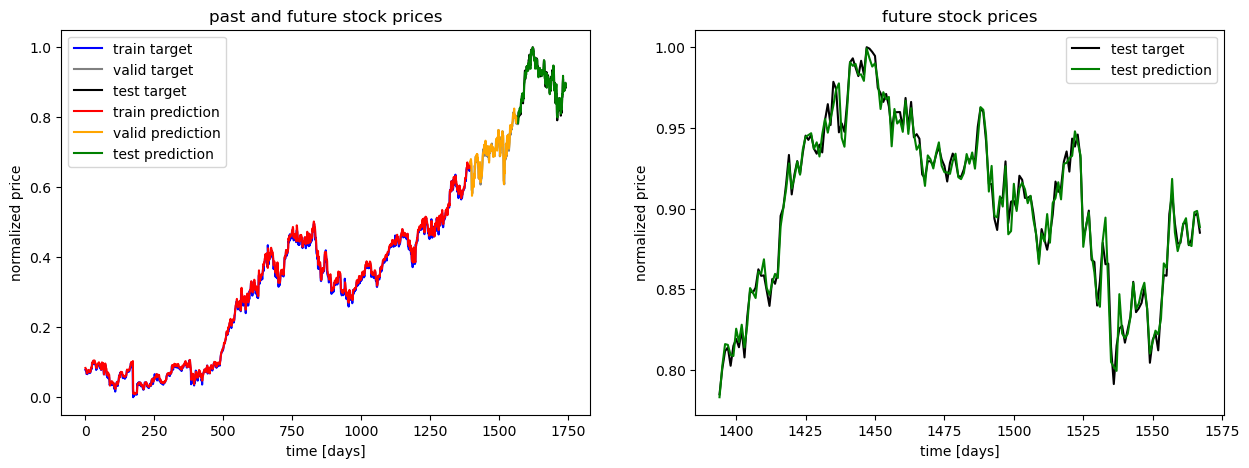

In [54]:
y_train_pred = model_lstm256.predict(X_train)
y_test_pred = model_lstm256.predict(X_test)
y_valid_pred = model_lstm256.predict(X_valid)

plot_predictions(
    y_train, 
    y_valid, 
    y_test, 
    y_train_pred, 
    y_valid_pred, 
    y_test_pred,
)

In [55]:
scores_df

,model_name,train_loss,val_loss
0,LSTM_2x200,0.000067,0.00007
1,GRU_2x200,0.000063,0.00007
2,LSTM_2x256,0.00007,0.000076


In [56]:
reset_seeds()
model_lstm256_dropout = Sequential()
model_lstm256_dropout.add(LSTM(256, input_shape=(X_train.shape[1], 4), return_sequences=True))
model_lstm256_dropout.add(Dropout(0.2))
model_lstm256_dropout.add(LSTM(256))
model_lstm256_dropout.add(Dense(1, activation = "linear"))

model_lstm256_dropout.compile(
    loss='mse', 
    optimizer='adam',
) 

history_lstm256_dropout = model_lstm256_dropout.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=100, 
    validation_split=0.2,
)

Epoch 1/100
23/23 [==============================] - 5s 129ms/step - loss: 0.0073 - val_loss: 3.5186e-04
Epoch 2/100
23/23 [==============================] - 2s 91ms/step - loss: 4.3819e-04 - val_loss: 4.5694e-04
Epoch 3/100
23/23 [==============================] - 2s 90ms/step - loss: 2.8165e-04 - val_loss: 5.0267e-04
Epoch 4/100
23/23 [==============================] - 2s 91ms/step - loss: 2.7144e-04 - val_loss: 4.4371e-04
Epoch 5/100
23/23 [==============================] - 2s 90ms/step - loss: 2.6114e-04 - val_loss: 7.1001e-04
Epoch 6/100
23/23 [==============================] - 2s 90ms/step - loss: 2.7980e-04 - val_loss: 4.4096e-04
Epoch 7/100
23/23 [==============================] - 2s 90ms/step - loss: 2.6091e-04 - val_loss: 3.7766e-04
Epoch 8/100
23/23 [==============================] - 2s 90ms/step - loss: 2.8319e-04 - val_loss: 2.9969e-04
Epoch 9/100
23/23 [==============================] - 2s 91ms/step - loss: 2.6587e-04 - val_loss: 2.7541e-04
Epoch 10/100
23/23 [===========

23/23 [==============================] - 2s 91ms/step - loss: 1.2828e-04 - val_loss: 1.3237e-04
Epoch 77/100
23/23 [==============================] - 2s 89ms/step - loss: 1.2758e-04 - val_loss: 1.5461e-04
Epoch 78/100
23/23 [==============================] - 2s 90ms/step - loss: 1.3881e-04 - val_loss: 2.9655e-04
Epoch 79/100
23/23 [==============================] - 2s 90ms/step - loss: 1.2681e-04 - val_loss: 4.1424e-04
Epoch 80/100
23/23 [==============================] - 2s 90ms/step - loss: 1.4730e-04 - val_loss: 1.6357e-04
Epoch 81/100
23/23 [==============================] - 2s 91ms/step - loss: 1.4450e-04 - val_loss: 1.7760e-04
Epoch 82/100
23/23 [==============================] - 2s 89ms/step - loss: 1.4369e-04 - val_loss: 3.7394e-04
Epoch 83/100
23/23 [==============================] - 2s 92ms/step - loss: 1.6010e-04 - val_loss: 2.1372e-04
Epoch 84/100
23/23 [==============================] - 2s 89ms/step - loss: 1.4269e-04 - val_loss: 1.1669e-04
Epoch 85/100
23/23 [============

In [57]:
history_lstm256_dropout = model_lstm256_dropout.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=100, 
    validation_split=0.2,
)

Epoch 1/100
23/23 [==============================] - 2s 92ms/step - loss: 1.4539e-04 - val_loss: 3.7241e-04
Epoch 2/100
23/23 [==============================] - 2s 90ms/step - loss: 1.1529e-04 - val_loss: 2.6450e-04
Epoch 3/100
23/23 [==============================] - 2s 90ms/step - loss: 1.5139e-04 - val_loss: 4.1064e-04
Epoch 4/100
23/23 [==============================] - 2s 90ms/step - loss: 1.3514e-04 - val_loss: 1.6561e-04
Epoch 5/100
23/23 [==============================] - 2s 92ms/step - loss: 1.0932e-04 - val_loss: 1.7832e-04
Epoch 6/100
23/23 [==============================] - 2s 90ms/step - loss: 1.1401e-04 - val_loss: 1.7320e-04
Epoch 7/100
23/23 [==============================] - 2s 90ms/step - loss: 1.1541e-04 - val_loss: 1.3483e-04
Epoch 8/100
23/23 [==============================] - 2s 89ms/step - loss: 1.1119e-04 - val_loss: 5.0356e-04
Epoch 9/100
23/23 [==============================] - 2s 90ms/step - loss: 1.6023e-04 - val_loss: 9.7224e-05
Epoch 10/100
23/23 [========

23/23 [==============================] - 2s 90ms/step - loss: 9.3081e-05 - val_loss: 1.2321e-04
Epoch 77/100
23/23 [==============================] - 2s 91ms/step - loss: 1.1089e-04 - val_loss: 8.3377e-05
Epoch 78/100
23/23 [==============================] - 2s 90ms/step - loss: 1.1069e-04 - val_loss: 1.1967e-04
Epoch 79/100
23/23 [==============================] - 2s 91ms/step - loss: 1.1337e-04 - val_loss: 1.0530e-04
Epoch 80/100
23/23 [==============================] - 2s 91ms/step - loss: 9.0927e-05 - val_loss: 1.1134e-04
Epoch 81/100
23/23 [==============================] - 2s 90ms/step - loss: 8.7232e-05 - val_loss: 8.0534e-05
Epoch 82/100
23/23 [==============================] - 2s 91ms/step - loss: 8.9829e-05 - val_loss: 2.6915e-04
Epoch 83/100
23/23 [==============================] - 2s 95ms/step - loss: 9.1619e-05 - val_loss: 7.5026e-05
Epoch 84/100
23/23 [==============================] - 2s 90ms/step - loss: 9.0837e-05 - val_loss: 8.3838e-05
Epoch 85/100
23/23 [============

🎯 Train Loss: 9.491825039731339e-05
🎯 Val Loss: 8.713192801224068e-05


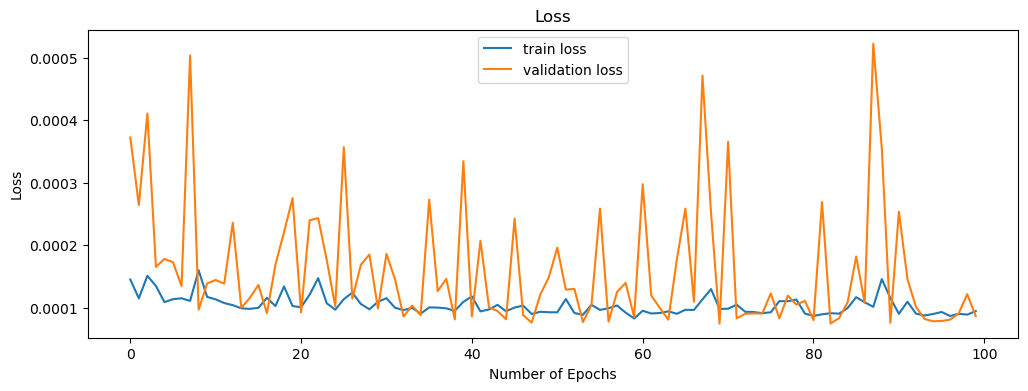

In [58]:
scores_df = plot_loss(
    history_lstm256_dropout,
    scores_df, 
    'LSTM_2x256_dropout',
)

6/6 [==============================] - 0s 20ms/step


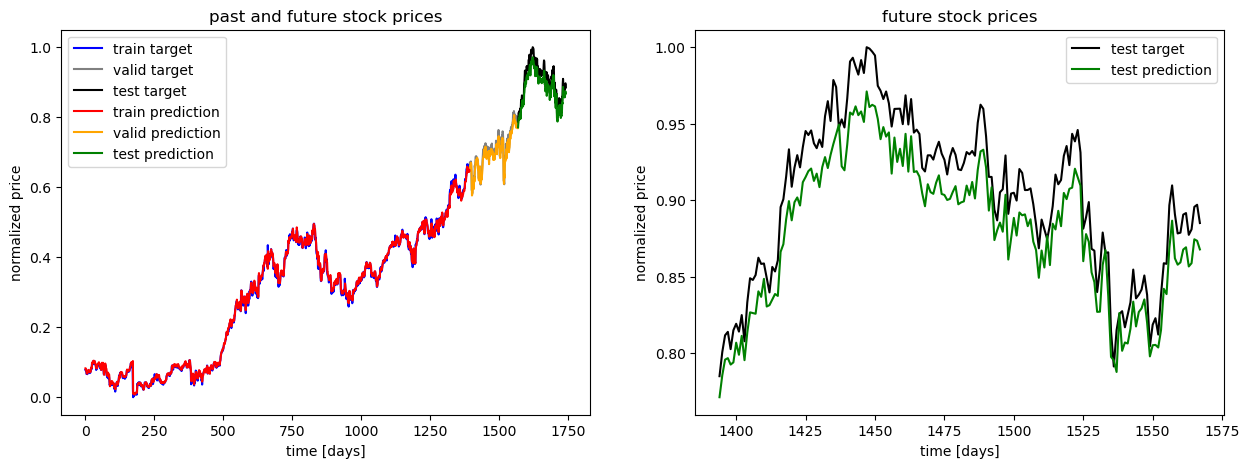

In [59]:
y_train_pred = model_lstm256_dropout.predict(X_train)
y_test_pred = model_lstm256_dropout.predict(X_test)
y_valid_pred = model_lstm256_dropout.predict(X_valid)

plot_predictions(
    y_train, 
    y_valid, 
    y_test, 
    y_train_pred, 
    y_valid_pred, 
    y_test_pred,
)

In [60]:
scores_df

,model_name,train_loss,val_loss
0,LSTM_2x200,0.000067,0.00007
1,GRU_2x200,0.000063,0.00007
2,LSTM_2x256,0.00007,0.000076
3,LSTM_2x256_dropout,0.000095,0.000087


In [61]:
reset_seeds()
model_lstm_split = Sequential()
model_lstm_split.add(LSTM(128, input_shape=(X_train.shape[1], 4), return_sequences=True))
model_lstm_split.add(LSTM(128, return_sequences=True))
model_lstm_split.add(LSTM(128, return_sequences=True))
model_lstm_split.add(LSTM(64))
model_lstm_split.add(Dense(1, activation = "linear"))

model_lstm_split.compile(
    loss='mse', 
    optimizer='adam',
) 

history_lstm_split = model_lstm_split.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=100, 
    validation_split=0.2,
)

Epoch 1/100
23/23 [==============================] - 7s 132ms/step - loss: 0.0086 - val_loss: 7.7231e-04
Epoch 2/100
23/23 [==============================] - 2s 77ms/step - loss: 7.7309e-04 - val_loss: 7.8937e-04
Epoch 3/100
23/23 [==============================] - 2s 78ms/step - loss: 5.6968e-04 - val_loss: 7.8075e-04
Epoch 4/100
23/23 [==============================] - 2s 80ms/step - loss: 5.7133e-04 - val_loss: 9.8252e-04
Epoch 5/100
23/23 [==============================] - 2s 73ms/step - loss: 5.4072e-04 - val_loss: 0.0023
Epoch 6/100
23/23 [==============================] - 2s 70ms/step - loss: 5.3623e-04 - val_loss: 0.0011
Epoch 7/100
23/23 [==============================] - 2s 72ms/step - loss: 5.3605e-04 - val_loss: 0.0017
Epoch 8/100
23/23 [==============================] - 2s 76ms/step - loss: 5.9376e-04 - val_loss: 9.8635e-04
Epoch 9/100
23/23 [==============================] - 2s 67ms/step - loss: 6.3427e-04 - val_loss: 8.3356e-04
Epoch 10/100
23/23 [=======================

Epoch 77/100
23/23 [==============================] - 1s 58ms/step - loss: 1.4200e-04 - val_loss: 1.1904e-04
Epoch 78/100
23/23 [==============================] - 1s 60ms/step - loss: 1.1605e-04 - val_loss: 9.9718e-05
Epoch 79/100
23/23 [==============================] - 1s 59ms/step - loss: 1.3464e-04 - val_loss: 1.5684e-04
Epoch 80/100
23/23 [==============================] - 1s 60ms/step - loss: 1.4463e-04 - val_loss: 1.8608e-04
Epoch 81/100
23/23 [==============================] - 1s 59ms/step - loss: 1.1759e-04 - val_loss: 9.0870e-05
Epoch 82/100
23/23 [==============================] - 1s 59ms/step - loss: 1.0283e-04 - val_loss: 3.1903e-04
Epoch 83/100
23/23 [==============================] - 1s 58ms/step - loss: 1.0436e-04 - val_loss: 8.6835e-05
Epoch 84/100
23/23 [==============================] - 1s 59ms/step - loss: 9.2428e-05 - val_loss: 1.0082e-04
Epoch 85/100
23/23 [==============================] - 1s 59ms/step - loss: 1.1120e-04 - val_loss: 1.6970e-04
Epoch 86/100
23/23 

🎯 Train Loss: 8.401548984693363e-05
🎯 Val Loss: 0.00011481646652100608


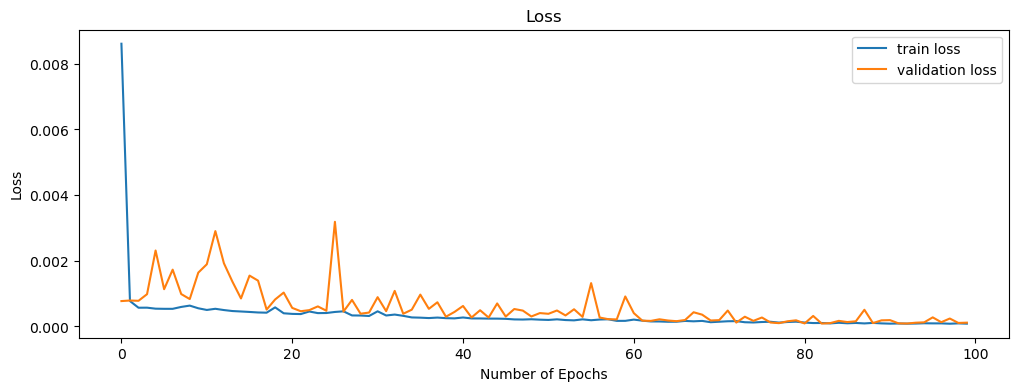

In [62]:
scores_df = plot_loss(
    history_lstm_split,
    scores_df,
    'LSTM_split',
)

6/6 [==============================] - 0s 18ms/step


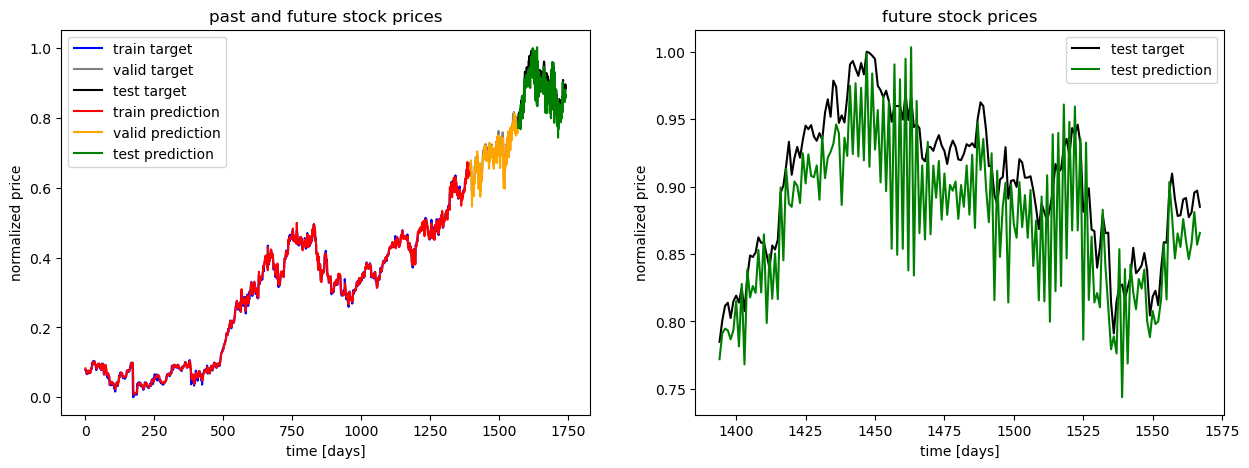

In [63]:
y_train_pred = model_lstm_split.predict(X_train)
y_test_pred = model_lstm_split.predict(X_test)
y_valid_pred = model_lstm_split.predict(X_valid)

plot_predictions(
    y_train, 
    y_valid, 
    y_test, 
    y_train_pred, 
    y_valid_pred, 
    y_test_pred,
)

In [64]:
scores_df

,model_name,train_loss,val_loss
0,LSTM_2x200,0.000067,0.00007
1,GRU_2x200,0.000063,0.00007
2,LSTM_2x256,0.00007,0.000076
3,LSTM_2x256_dropout,0.000095,0.000087
4,LSTM_split,0.000084,0.000115


In [65]:
reset_seeds()
model_lstm = Sequential()
model_lstm.add(LSTM(180, input_shape=(X_train.shape[1], 4), return_sequences=True))
model_lstm.add(LSTM(180))
model_lstm.add(Dense(4, activation = "linear"))
model_lstm.compile(
    loss='mse', 
    optimizer='adam',
) 

In [66]:
history_lstm = model_lstm.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=100, 
    validation_split=0.2,
)

Epoch 1/100
23/23 [==============================] - 4s 81ms/step - loss: 0.0088 - val_loss: 0.0056
Epoch 2/100
23/23 [==============================] - 1s 54ms/step - loss: 5.7889e-04 - val_loss: 5.0874e-04
Epoch 3/100
23/23 [==============================] - 1s 55ms/step - loss: 3.3888e-04 - val_loss: 5.6633e-04
Epoch 4/100
23/23 [==============================] - 1s 55ms/step - loss: 3.2289e-04 - val_loss: 5.9596e-04
Epoch 5/100
23/23 [==============================] - 1s 54ms/step - loss: 3.0138e-04 - val_loss: 0.0011
Epoch 6/100
23/23 [==============================] - 1s 56ms/step - loss: 2.9770e-04 - val_loss: 5.7763e-04
Epoch 7/100
23/23 [==============================] - 1s 54ms/step - loss: 2.8917e-04 - val_loss: 5.9212e-04
Epoch 8/100
23/23 [==============================] - 1s 56ms/step - loss: 3.1186e-04 - val_loss: 4.7320e-04
Epoch 9/100
23/23 [==============================] - 1s 57ms/step - loss: 3.2992e-04 - val_loss: 4.7860e-04
Epoch 10/100
23/23 [====================

23/23 [==============================] - 1s 55ms/step - loss: 8.9485e-05 - val_loss: 9.2665e-05
Epoch 77/100
23/23 [==============================] - 1s 55ms/step - loss: 9.0080e-05 - val_loss: 8.6533e-05
Epoch 78/100
23/23 [==============================] - 1s 56ms/step - loss: 8.1297e-05 - val_loss: 1.3768e-04
Epoch 79/100
23/23 [==============================] - 1s 55ms/step - loss: 8.9335e-05 - val_loss: 1.1316e-04
Epoch 80/100
23/23 [==============================] - 1s 54ms/step - loss: 8.4321e-05 - val_loss: 1.0226e-04
Epoch 81/100
23/23 [==============================] - 1s 56ms/step - loss: 7.9240e-05 - val_loss: 8.8634e-05
Epoch 82/100
23/23 [==============================] - 1s 56ms/step - loss: 7.8742e-05 - val_loss: 1.7028e-04
Epoch 83/100
23/23 [==============================] - 1s 55ms/step - loss: 7.8699e-05 - val_loss: 9.1671e-05
Epoch 84/100
23/23 [==============================] - 1s 54ms/step - loss: 7.3021e-05 - val_loss: 9.5105e-05
Epoch 85/100
23/23 [============

🎯 Train Loss: 6.752501212758943e-05
🎯 Val Loss: 7.787229696987197e-05


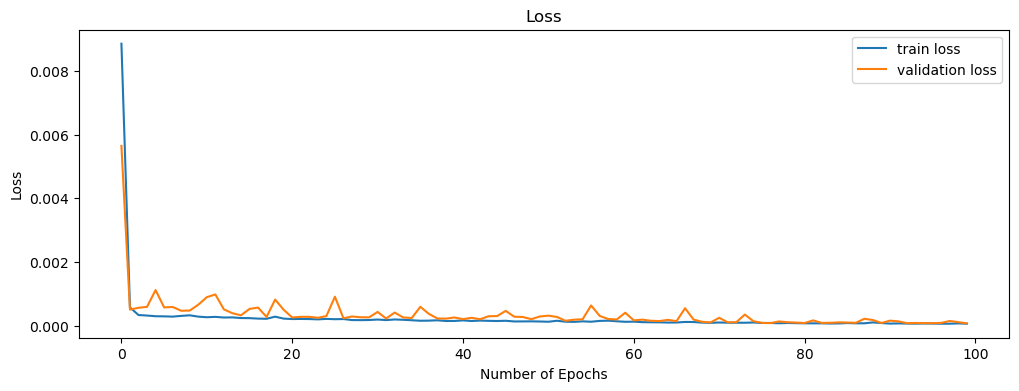

In [67]:
scores_df = plot_loss(
    history_lstm,
    scores_df,
    'LSTM_2x180',
)

6/6 [==============================] - 0s 14ms/step


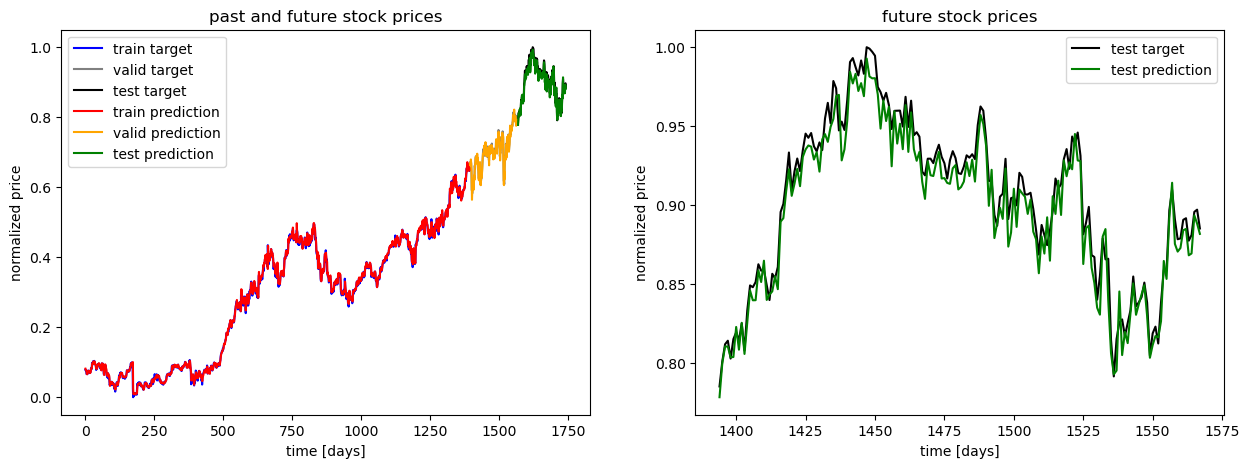

In [68]:
y_train_pred = model_lstm.predict(X_train)
y_test_pred = model_lstm.predict(X_test)
y_valid_pred = model_lstm.predict(X_valid)

plot_predictions(
    y_train, 
    y_valid, 
    y_test, 
    y_train_pred, 
    y_valid_pred, 
    y_test_pred,
)

<a name='33'></a>
## <span style="color:#ff5f27">📝 Results</span>
- [🗄️ Table of Contents](#0_0)

In [69]:
scores_df

,model_name,train_loss,val_loss
0,LSTM_2x200,0.000067,0.00007
1,GRU_2x200,0.000063,0.00007
2,LSTM_2x256,0.00007,0.000076
3,LSTM_2x256_dropout,0.000095,0.000087
4,LSTM_split,0.000084,0.000115
5,LSTM_2x180,0.000068,0.000078


- [🗄️ Table of Contents](#0_0)
---